Importar librerias requeridas

In [1]:
import ee 
import geemap
import json
import os
import pandas as pd
import matplotlib.pyplot as plt


Autenticación con GEE y extracción de zona de estudio

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-rimartinezs')

In [3]:
with open(os.path.join(os.getcwd(), '..', 'data', 'Localidad_Usme.geojson')) as geojson:
    data = json.load(geojson)

zona_estudio = ee.FeatureCollection(data)

Calculo del NDVI de la imagen con menos cobertura de nubes

In [6]:
# Colección Landsat 8
l8Col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(zona_estudio) \
    .filterDate('2023-01-01', '2023-12-31')\
    .filter(ee.Filter.lt('CLOUD_COVER', 50))

# Recortar imágenes
def recortar(img):
    return img.clip(zona_estudio)
aoi_L8col = l8Col.map(recortar)

# Rescalar imágenes
escala = 0.0000275
inter = -0.2
def rescalar(img):
    bands = img.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])
    scaled = bands.multiply(escala).add(inter)
    return scaled.copyProperties(img, img.propertyNames())
aoi_L8_sr = aoi_L8col.map(rescalar)

# Calcular NDVI
def calcNDVI(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi).copyProperties(image, image.propertyNames())
    
l8Ndvi = aoi_L8_sr.map(calcNDVI)

#Imagen con menos nubes
ImageNDVI = l8Ndvi.sort('CLOUD_COVER').first()

ndvi_palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
                '74A901', '66A000', '529400', '3E8601', '207401', '056201',
                '004C00', '023B01', '012E01', '011D01', '011301']

ImageNDVI_id = ImageNDVI.getInfo()['id']
print(ImageNDVI_id)
print('Número de imágenes:', aoi_L8col.size().getInfo())

LANDSAT/LC08/C02/T1_L2/LC08_008057_20230603
Número de imágenes: 9


In [7]:
with open(os.path.join(os.getcwd(), '..', 'data', 'Voronoi_Poligons_Usme.geojson')) as geojson:
    data = json.load(geojson)

Poligons = ee.FeatureCollection(data)

Visualización Poligonos y NDVI

In [ ]:
Map = geemap.Map()
Map.centerObject(zona_estudio, 10)
Map.addLayer(zona_estudio, {}, 'Localidad de Usme')
Map.addLayer(Poligons, {}, 'Polygons')
Map.addLayer(ImageNDVI.select('NDVI'), {'min': 0, 'max': 1, 'palette': ndvi_palette}, 'NDVI')
Map

Map(center=[4.390019031052832, -74.14281202673868], controls=(WidgetControl(options=['position', 'transparent_…

Verificación cobertura de cada imagen sobre el área de estudio

In [ ]:
imagenes = aoi_L8col.toList(aoi_L8col.size())
area_total = zona_estudio.geometry().area().getInfo()

resultados = []

for i in range(aoi_L8col.size().getInfo()):
    img = ee.Image(imagenes.get(i))
    img_id = img.id().getInfo()  
    mascara_valida = img.select(0).mask().gt(0)
    pix_area = ee.Image.pixelArea().updateMask(mascara_valida)
    area_cubierta = pix_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=zona_estudio.geometry(),
        scale=10,
        maxPixels=1e10
    ).get('area').getInfo()
    porcentaje_cobertura = (area_cubierta / area_total) * 100 if area_total > 0 else 0
    resultados.append({'id': img_id, 'area_cubierta': area_cubierta, 'porcentaje': porcentaje_cobertura})

# Ordenar por porcentaje de cobertura descendente
resultados_ordenados = sorted(resultados, key=lambda x: x['porcentaje'], reverse=True)

# Mostrar resultados
for r in resultados_ordenados:
    print(f"Imagen: {r['id']}, Área cubierta: {r['area_cubierta']:.2f} m², Porcentaje: {r['porcentaje']:.2f}%")


Imagen: LC08_008057_20231212, Área cubierta: 214860022.72 m², Porcentaje: 99.54%
Imagen: LC08_008057_20230619, Área cubierta: 214815969.11 m², Porcentaje: 99.52%
Imagen: LC08_008057_20230518, Área cubierta: 214730601.59 m², Porcentaje: 99.48%
Imagen: LC08_008057_20231009, Área cubierta: 214724621.16 m², Porcentaje: 99.48%
Imagen: LC08_008057_20230211, Área cubierta: 214643470.36 m², Porcentaje: 99.44%
Imagen: LC08_008057_20230603, Área cubierta: 214627475.45 m², Porcentaje: 99.44%
Imagen: LC08_008057_20230923, Área cubierta: 214595299.23 m², Porcentaje: 99.42%
Imagen: LC08_008057_20231126, Área cubierta: 213976055.32 m², Porcentaje: 99.14%
Imagen: LC08_008057_20230227, Área cubierta: 213727059.90 m², Porcentaje: 99.02%


Calculo NDVI de cada imagen

In [ ]:
imagenes = aoi_L8col.toList(aoi_L8col.size())
n_imagenes = aoi_L8col.size().getInfo()

resultados = []

for i in range(n_imagenes):
    img = ee.Image(imagenes.get(i))
    img_id = img.id().getInfo()
    fecha = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()

    ndvi = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

    stats = ndvi.reduceRegions(
        collection=Poligons,
        reducer=ee.Reducer.mean(),
        scale=30
    ).getInfo()

    for feature in stats['features']:
        props = feature['properties']
        props['imagen_id'] = img_id
        props['date'] = fecha
        resultados.append(props)

Guardar calculos del NDVI en un df

In [ ]:
df = pd.DataFrame(resultados)
df = df.rename(columns={'mean': 'NDVI_mean'})  
df['date'] = pd.to_datetime(df['date'])

Grafico NDVI en series de tiempo

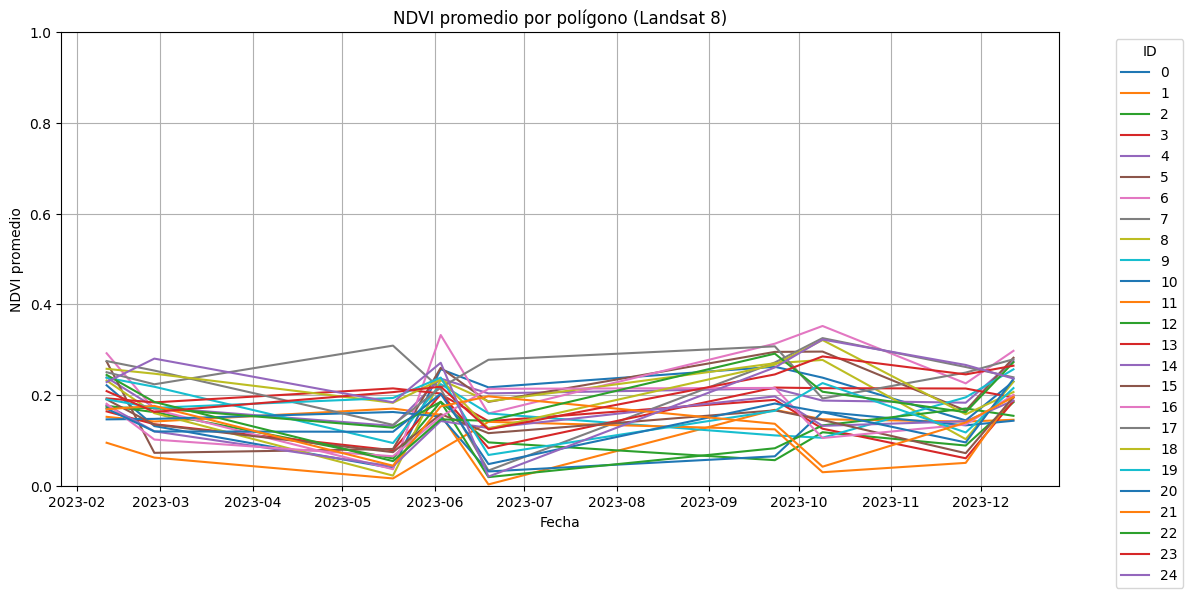

In [ ]:
plt.figure(figsize=(12, 6))

# Agrupación por el ID de cada polígono
for key, grp in df.groupby('rand_point_id'):
    plt.plot(grp['date'], grp['NDVI_mean'], label=str(key))

plt.title('NDVI promedio por polígono (Landsat 8)')
plt.xlabel('Fecha')
plt.ylabel('NDVI promedio')
plt.ylim(0, 1)
plt.legend(title='ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
